In [1]:
import pytest
def run_tests():
    pytest.main(args=['-v','--tb=short','--color=yes'])

In [2]:
import numpy as np

def syntheticY(n):
    """
    Synthetic rank-2 n x n matrix
    """
    U = np.vstack((np.arange(n)/n, (1-np.arange(n)/n)**2)).T
    W = np.vstack((np.arange(n)/n, (1-np.arange(n)/n)**2)).T
    return U @ W.T

def bernoulli(n,p):
    """
    Bernoulli sampling.
    Produces a set of index pairs I = {(i1,i2)} where
    i1,i2 = 0,...,n-1, and each pair is sampled with 
    probability p
    """
    I1, I2 = np.meshgrid(np.arange(n), np.arange(n))
    I1 = I1.flatten()
    I2 = I2.flatten()
    I = []
    for i1,i2 in zip(I1,I2):
        if (np.random.rand()<p):
            I.append([i1,i2])
    return np.array(I)

def Loss(U,W,Y,I):
    """
    Loss function (2), where 
    U, W are n x r factor matrices,
    Y is a n x n data matrix, 
    and I is a m x 2 matrix of index pairs
    """
    L = 0
    for i1,i2 in I:
        L = L + (U[i1] @ W[i2] - Y[i1,i2])**2
    return L / I.shape[0]

def initial(n,r):
    """
    Initial guess of the matrix factors
    """
    U0 = np.vstack((np.identity(r), np.zeros((n-r,r))))
    W0 = np.vstack((np.identity(r), np.zeros((n-r,r))))
    return U0, W0


def test_pointwise_gradient_1():
    """
    Unit tests for the pointwise gradient
    """
    Y = syntheticY(4)
    U,W = initial(4,2)
    vu = np.array([0,-1.125])
    vw = np.array([-1.125,0])
    assert np.array_equal(pointwise_gradient(U,W,Y,0,1), [vu, vw])
    
def test_pointwise_gradient_2():    
    Y = syntheticY(4)
    U,W = initial(4,2)
    vu = np.array([0,0])
    vw = np.array([-0.5,0])
    assert np.array_equal(pointwise_gradient(U,W,Y,0,2), [vu, vw])
    
def test_pointwise_gradient_3():        
    Y = syntheticY(4)
    U,W = initial(4,2)    
    vu = np.array([-0.5,0])
    vw = np.array([0,0])
    assert np.array_equal(pointwise_gradient(U,W,Y,2,0), [vu, vw])
    
    
def test_full_gradient_1():
    """
    Unit tests for the full gradient
    """
    Y = syntheticY(4)
    U,W = initial(4,2)
    Gu = np.array([[0,-1.125], [0,     0], [0,0], [0,0]])
    Gw = np.array([[0,     0], [-1.125,0], [0,0], [0,0]])
    assert np.array_equal(full_gradient(U,W,Y, np.array([[0,1]])), [Gu, Gw])    
    
def test_full_gradient_2():
    Y = syntheticY(4)
    U,W = initial(4,2)
    Gu = np.array([[0,    0], [-9/16,0], [0,   0], [0,0]]) 
    Gw = np.array([[0,-9/16], [0,    0], [-1/4,0], [0,0]])
    assert np.array_equal(full_gradient(U,W,Y, np.array([[1,0], [0,2]])), [Gu, Gw])    
    
def test_full_gradient_3():
    Y = syntheticY(4)
    U,W = initial(4,2)
    Gu = np.array([[0,-9/32], [-9/32,0], [-1/8,0], [0,0]]) 
    Gw = np.array([[0,-9/32], [-9/32,0], [0,   0], [0,0]])
    assert np.array_equal(full_gradient(U,W,Y, np.array([[1,0], [0,1], [2,0], [0,0]])), [Gu, Gw])    

### Q1: pointwise loss gradient

In [3]:
def pointwise_gradient(U, W, Y, i1, i2):
    # Calculates vu and vw using the formula given
    vu = 2*(np.matmul(U[i1], W[i2].T) - Y[i1, i2]) * W[i2]
    vw = 2*(np.matmul(U[i1], W[i2].T) - Y[i1, i2]) * U[i1]
    return vu, vw

### Q2: full gradient

In [4]:
def full_gradient(U, W, Y, I):
    # initialise Gu and Gw as n x r 0 matrix
    Gu = np.zeros(shape = np.shape(U))
    Gw = np.zeros(shape = np.shape(U))
    
    # loop over each row (permutation) of index set I
    for i in I:
        # each row is of form [i1, i2]
        i1 , i2 = i[0], i[1] 
        
        # compute vu and vw using pointwise_gradient function
        vu, vw = pointwise_gradient(U, W, Y, i1, i2)
        
        # increment i1th row of Gu and i2th row of Gw
        Gu[i1] += vu
        Gw[i2] += vw
    
    # divide by number of permutations
    m = np.shape(I)[0]
    Gu = Gu / m
    Gw = Gw / m
    return Gu, Gw

In [5]:
run_tests() # looks good

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /opt/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /mount/jupyter/jupyter-wh607/MA20278_workspace/Coursework
plugins: timeout-1.4.2, anyio-2.2.0, jupyter-pytest-2-1.0.1
collecting ... collected 6 items

::test_pointwise_gradient_1 PASSED                                       [ 16%]
::test_pointwise_gradient_2 PASSED                                       [ 33%]
::test_pointwise_gradient_3 PASSED                                       [ 50%]
::test_full_gradient_1 PASSED                                            [ 66%]
::test_full_gradient_2 PASSED                                            [ 83%]
::test_full_gradient_3 PASSED                                            [100%]

============================== 6 passed in 0.16s ===============================


### Q3: gradient descent

In [6]:
import matplotlib.pyplot as plt

In [7]:
def gd(U0, W0, Y, I, Itest, t = 1, eps = 1e-6, K = 100, re = False):
    """
    Gradient descent algorithm for matrix completion.
    
    Arguments:
    U0, W0: initial guesses of U and W.
    Y: n x n data matrix.
    I: m x 2 index set.
    Itest: mu x 2 test index set.
    
    Optional arguments:
    t: 1 by default, learning rate > 0.
    eps: 1e-6 by default, stopping tolerance > 0.
    K: 100 by default, maximum number of iterations
    re: FALSE by default, whether or not relative error should be calculated
        and plotted. If not interested in relative error, do not change
        to save computation time.
    """
    # initialise U and W as the initial guess
    U , W = np.copy(U0), np.copy(W0) # np arrays are mutable, so need to copy them
    
    # initialise vectors to store  
    # test loss and relative error values
    test_loss = np.empty(shape = K)
    if re == True:
        relative_error = np.empty(shape = K)
    
    # run K iterations, breaking early if convergence achieved
    for k in range(K):
        # calculate the test loss and store it
        test_loss[k] = Loss(U, W, Y, Itest)
        
        # calculate the relative error and store it
        if re == True:
            relative_error[k] = np.linalg.norm(np.matmul(U, W.T) - Y)/np.linalg.norm(Y)
        
        if test_loss[k] < eps:
            # stop iterations if sufficiently small loss
            break
        
        elif test_loss[k] > np.exp(10):
            # stop iterations if trajectory is diverging to prevent
            # overflow
            break
        
        # calculate Gu and Gw using the full gradient algorithm
        Gu, Gw = full_gradient(U, W, Y, I)
        
        # update the iterates
        U -= t * Gu
        W -= t * Gw
 

    # vector 1, 2, ... , number of iterations
    k_vec = np.arange(1, k + 2)
    
    # plot test loss value on log scale against iteration number k
    plt.figure()
    plt.plot(k_vec, np.log(test_loss[:k+1]))
    plt.title(f'Test loss vs iteration number (t = {t})')
    plt.xlabel('k (iteration number)')
    plt.ylabel('logged test loss')
    
    # also plot the relative error on a log scale
    if re == True:
        plt.figure()
        plt.plot(k_vec, np.log(relative_error[:k+1]))
        plt.title(f'Relative error vs iteration number (t = {t})')
        plt.xlabel('k (iteration number)')
        plt.ylabel('logged relative error')
    
    return U, W

### Q4: testing GD on full data

In [9]:
Y_Q4 = syntheticY(n = 32)
Iext_Q4 = bernoulli(n = 32, p = 1) # all possible pairs of integers up to n = 32
U0_Q4, W0_Q4 = initial(n = 32, r = 2)

# extract 20 distinct index pairs uniformly at random from Iext
indices_Q4 = np.random.choice(np.shape(Iext_Q4)[0], size = 20, replace = False)
Itest_Q4 = Iext_Q4[indices_Q4]

# calculate the training set as the unsampled pairs
I_Q4 = np.delete(Iext_Q4, indices_Q4, axis = 0)

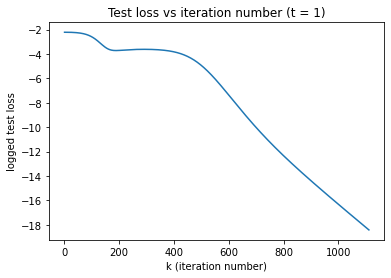

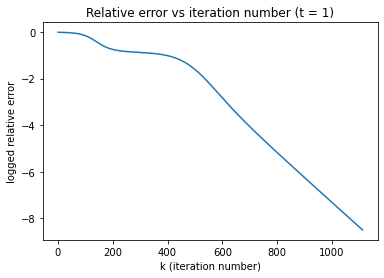

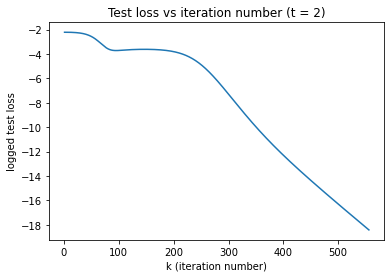

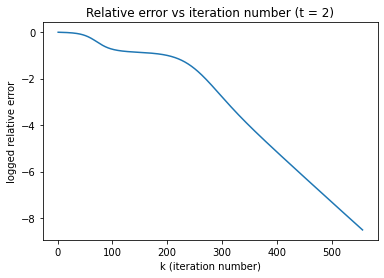

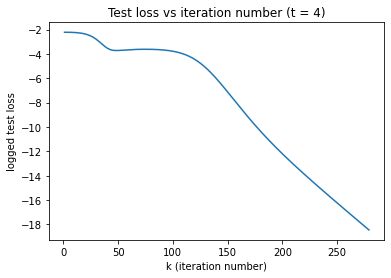

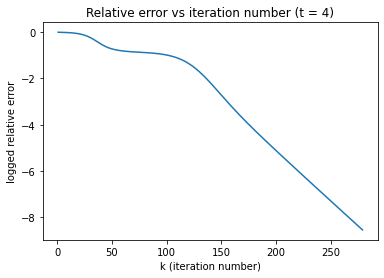

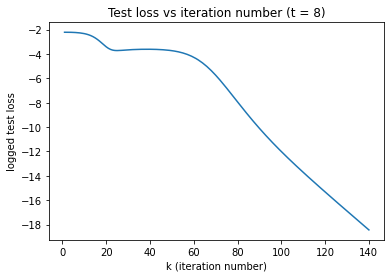

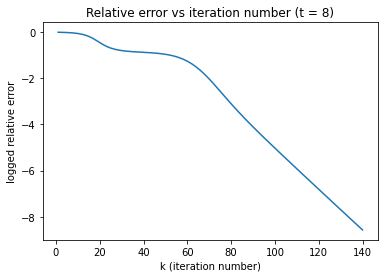

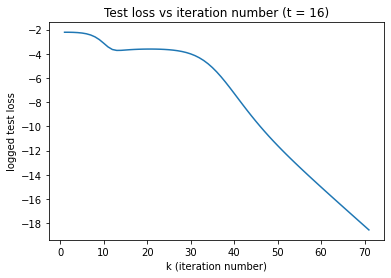

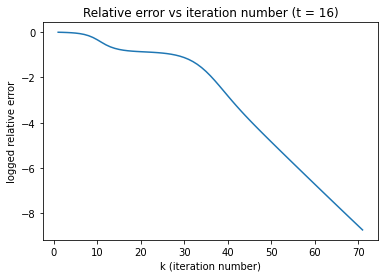

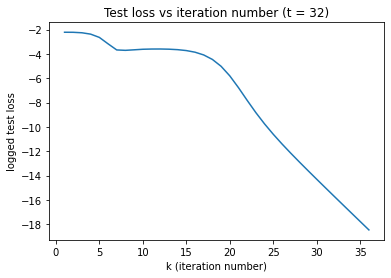

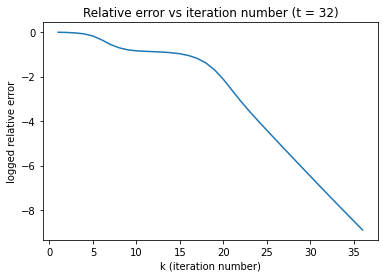

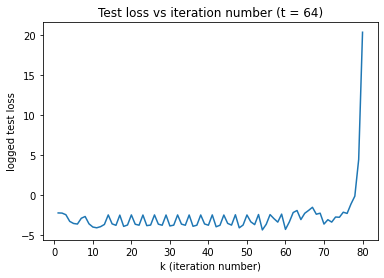

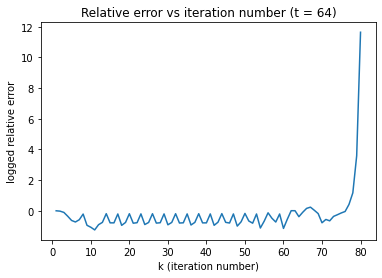

In [10]:
plt.close()
tset = [1,2,4,8,16,32,64]
for t in tset:
    gd(W0_Q4, U0_Q4, Y_Q4, I_Q4, Itest_Q4, t = t, eps = 1e-8, K = 5000, re = True)
plt.show()

### Q5: stochastic average gradient

In [48]:
def sag(U0, W0, Y, I, Itest, t = 1, eps = 1e-6, K = 100, re = False):
    """
    Stochastic average gradient algorithm for matrix completion.
    
    Arguments:
    U0, W0: initial guesses of U and W.
    Y: n x n data matrix.
    I: m x 2 index set.
    Itest: mu x 2 test index set.
    
    Optional arguments:
    t: 1 by default, learning rate > 0.
    eps: 1e-6 by default, stopping tolerance > 0.
    K: 100 by default, maximum number of iterations
    re: FALSE by default, whether or not relative error should be calculated
        and plotted. If not interested in relative error, do not change
        to save computation time.
    """
    # initialise iterates
    U, W = np.copy(U0), np.copy(W0)
    
    # intialise pointwise loss gradients
    m = np.shape(I)[0]
    r = np.shape(U0)[1]
    Vu = np.zeros(shape = (m, r))
    Vw = np.zeros(shape = (m, r))
    
    #initialise average approximation of the gradient
    Gu = np.zeros(shape = np.shape(U0))
    Gw = np.zeros(shape = np.shape(W0))
    
    # initialise vectors to store  
    # test loss and relative error values
    test_loss = np.empty(shape = K)
    if re == True:
        relative_error = np.empty(shape = K)
    
    for k in range(K):
        # calculate the test loss and store it
        test_loss[k] = Loss(U, W, Y, Itest)
        
        if re == True:
            # calculate the relative error and store it
            relative_error[k] = np.linalg.norm(np.matmul(U, W.T) - Y)/np.linalg.norm(Y)
        
        if test_loss[k] < eps:
            # stop iterations if sufficiently small loss
            break
 
        elif test_loss[k] > np.exp(8):
            # stop iterations if trajectory is diverging to prevent
            # overflow
            break
            
        # sample a random pair from the index set
        i = np.random.randint(0, m)
        (i1, i2) = I[i]
        
        # subtract the old gradients
        Gu[i1] -= 1/m * Vu[i]
        Gw[i2] -= 1/m * Vw[i]
        
        # compute pointwise loss gradients using pointwise_gradient function
        Vu[i], Vw[i] = pointwise_gradient(U, W, Y, i1, i2)
        
        # add new gradients
        Gu[i1] += 1/m * Vu[i]
        Gw[i2] += 1/m * Vw[i]
        
        # update iterates
        U -= t * Gu
        W -= t * Gw

    # vector 1, 2, ... , number of iterations
    k_vec = np.arange(1, k + 2)
    
    # plot test loss value on log scale against iteration number k
    plt.figure()
    plt.plot(k_vec, np.log(test_loss[:k+1]))
    plt.title(f'Test loss vs iteration number (t = {t})')
    plt.xlabel('k (iteration number)')
    plt.ylabel('logged test loss')
    
    # also plot the relative error on a log scale
    if re == True:
        plt.figure()
        plt.plot(k_vec, np.log(relative_error[:k+1]))
        plt.title(f'Relative error vs iteration number (t = {t})')
        plt.xlabel('k (iteration number)')
        plt.ylabel('logged relative error')
    
    return U, W

### Q6: testing SAG on full data

In [13]:
Y_Q6 = syntheticY(n = 32)
Iext_Q6 = bernoulli(n = 32, p = 1) # all possible pairs of integers up to n = 32
U0_Q6, W0_Q6 = initial(n = 32, r = 2)

# extract 20 distinct index pairs uniformly at random from Iext_Q6
indices_Q6 = np.random.choice(np.shape(Iext_Q6)[0], size = 20, replace = False)
Itest_Q6 = Iext_Q6[indices_Q6]
# calculate the training set as the unsampled pairs
I_Q6 = np.delete(Iext_Q6, indices_Q6, axis = 0)

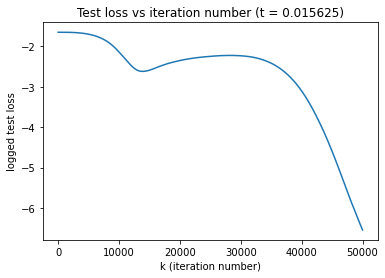

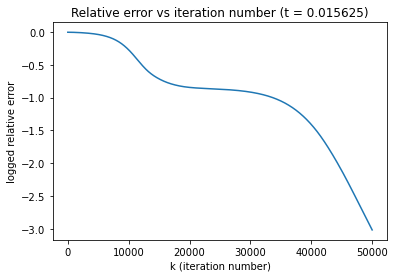

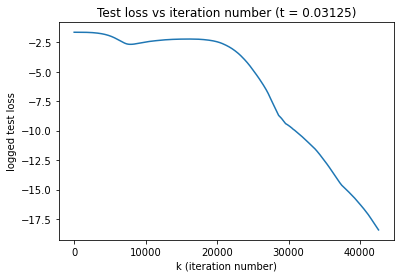

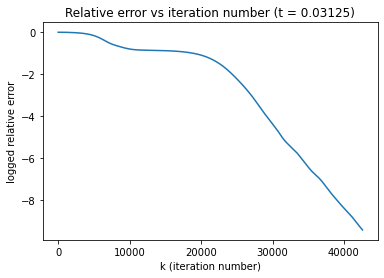

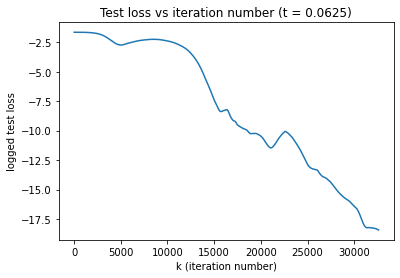

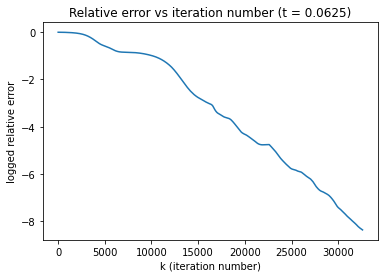

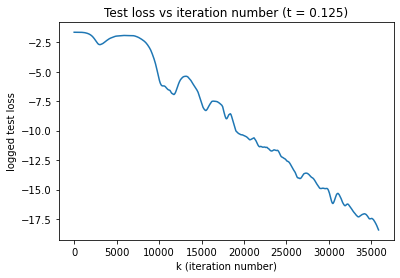

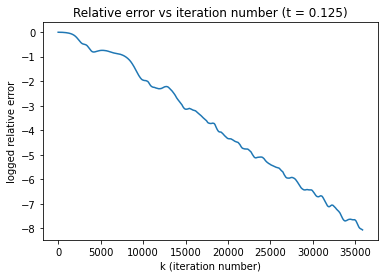

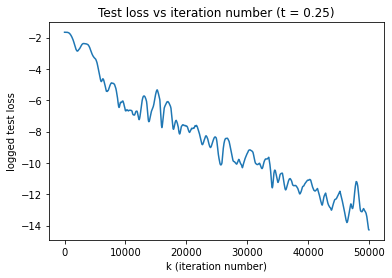

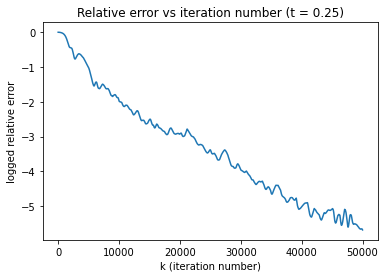

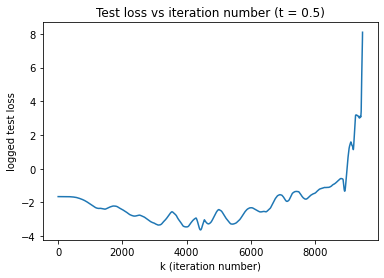

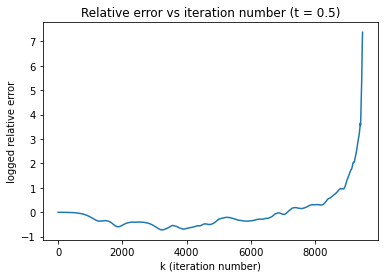

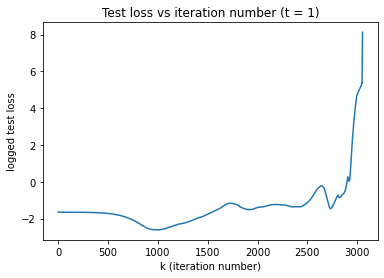

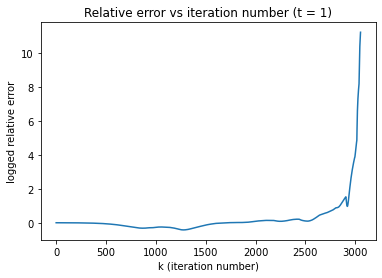

In [49]:
plt.close()
tset = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]
for t in tset:
    sag(U0_Q6, W0_Q6, Y_Q6, I_Q6, Itest_Q6, t = t, eps = 1e-8, K = 50000, re = True)
plt.show()

### Q7: tests with real data.

In [15]:
data = np.load('CW.npz')
Y_Q7 = data['Y']
n = np.shape(Y_Q7)[0]

Let's have a quick look at the X-ray data as an image:

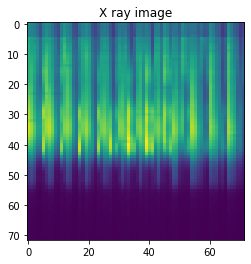

In [70]:
plt.imshow(Y_Q7)
plt.title('X ray image')
plt.savefig('Xrayimage.png')
plt.show()

In [17]:
# generate Iext of undersampling ratio p = 1/3
Iext_Q7 = bernoulli(n, 1/3)

# extract 20 distinct index pairs uniformly at random from Iext
indices_Q7 = np.random.choice(np.shape(Iext_Q7)[0], size = 20, replace = False)
Itest_Q7 = Iext_Q7[indices_Q7]
# calculate the training set as the unsampled pairs
I_Q7 = np.delete(Iext_Q7, indices_Q7, axis = 0)

In [18]:
# generate initial guesses of W and U with r = 4
U0_Q7, W0_Q7 = initial(n, 4)

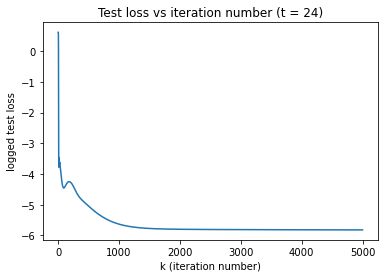

In [74]:
Utemp_gd, Wtemp_gd = gd(U0_Q7, W0_Q7, Y_Q7, I_Q7, Itest_Q7, t = 24, eps = 1e-8, K = 5000)

In [75]:
np.log(Loss(Utemp_gd, Wtemp_gd, Y_Q7, Itest_Q7))

-5.818858842036878

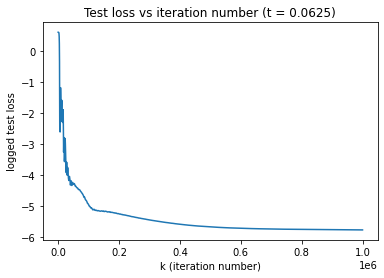

In [37]:
Utemp_sag, Wtemp_sag = sag(U0_Q7, W0_Q7, Y_Q7, I_Q7, Itest_Q7, t = 1/16, eps = 1e-8, K = 1000000)

In [38]:
np.log(Loss(Utemp_sag, Wtemp_sag, Y_Q7, Itest_Q7))

-5.775395822125952

After some experimenting and re-runs to vary the test set, ~$e^{-5.8}$ looks like the minimum that we can realistically achieve with both algorithms. SAG needs a lot of iterations to get there though.

In [39]:
eps = 2 * np.exp(-5.8)

First try gradient descent:

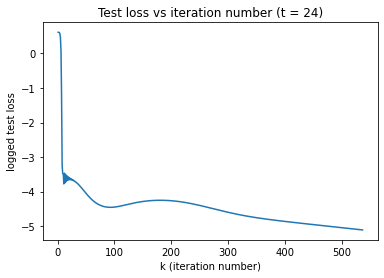

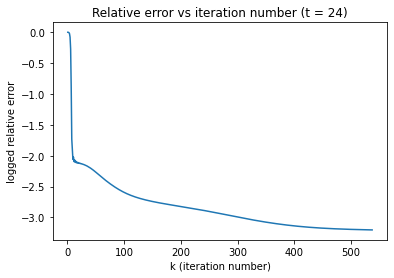

In [40]:
Ugd, Wgd = gd(U0_Q7, W0_Q7, Y_Q7, I_Q7, Itest_Q7, t = 24, eps = eps, K = 5000, re = True)
# t ~= 24 gives fastest convergence, going a little high causes
# the step size to be too big and gd oscillates around the solution

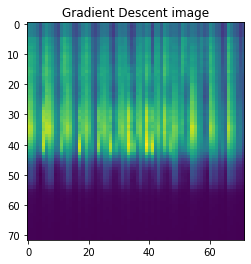

In [71]:
Cgd = np.matmul(Ugd ,Wgd.T)
plt.imshow(Cgd)
plt.title('Gradient Descent image')
plt.savefig('gdimage.png')
plt.show()

Looks very similar to the original.

Now let's try stochastic average gradient:

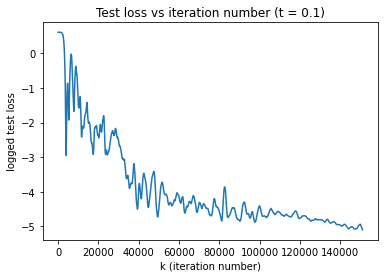

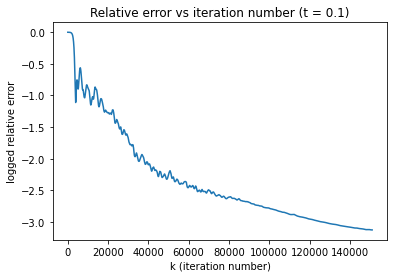

In [60]:
Usag, Wsag = sag(U0_Q7, W0_Q7, Y_Q7, I_Q7, Itest_Q7, t = 1/10, eps = eps, K = 1000000, re = True)

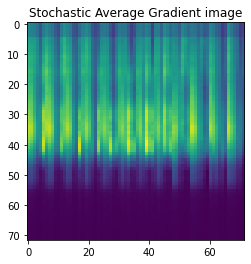

In [72]:
Csag = np.matmul(Usag ,Wsag.T)
plt.imshow(Csag)
plt.title('Stochastic Average Gradient image')
plt.savefig('sagimage.png')
plt.show()

This also looks extremely similar to the original.